In [10]:
%matplotlib inline
import math
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Using TensorFlow backend.


In [2]:
hpi = pd.DataFrame(pd.read_csv('../Data/hpi_final.csv'))

In [3]:
hpi = hpi[['county', 'year', 'hpi','one_year', 'two_years', 'three_years',
       'four_years', 'five_years'
          ]]

hpi.rename(columns={'county': 'county_code'}, inplace=True)

In [4]:
hpi.head()

,county_code,year,hpi,one_year,two_years,three_years,four_years,five_years
0,10001,1986,100.000000,0.057325,0.123340,0.194460,0.217233,0.204775
1,10001,1987,105.732500,0.062436,0.129700,0.151239,0.139456,0.065417
2,10001,1988,112.334000,0.063311,0.083584,0.072494,0.002806,0.001800
3,10001,1989,119.446000,0.019066,0.008636,-0.056902,-0.057848,-0.069229
4,10001,1990,121.723333,-0.010235,-0.074547,-0.075475,-0.086643,-0.073668


In [5]:
hpi2 = hpi.set_index(['county_code', 'year'])
hpi2.head()

hpi  one_year  two_years  three_years  four_years  \
county_code year                                                             
10001       1986  100.000000  0.057325   0.123340     0.194460    0.217233   
            1987  105.732500  0.062436   0.129700     0.151239    0.139456   
            1988  112.334000  0.063311   0.083584     0.072494    0.002806   
            1989  119.446000  0.019066   0.008636    -0.056902   -0.057848   
            1990  121.723333 -0.010235  -0.074547    -0.075475   -0.086643   

                  five_years  
county_code year              
10001       1986    0.204775  
            1987    0.065417  
            1988    0.001800  
            1989   -0.069229  
            1990   -0.073668

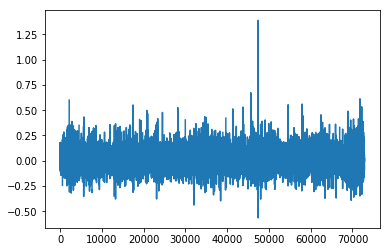

In [6]:
dataset = pd.read_csv('../Data/hpi_final.csv', usecols=[3], engine='python')
plt.plot(dataset)
plt.show()

In [7]:
hpi3 = hpi2['hpi']
hpi3.head()

county_code  year
10001        1986    100.000000
             1987    105.732500
             1988    112.334000
             1989    119.446000
             1990    121.723333
Name: hpi, dtype: float64

In [8]:
hpi3 = hpi3.replace([np.inf, -np.inf], np.nan)
hpi3 = hpi3.dropna()

In [9]:
hpi_data = hpi3.values
hpi_data = hpi_data.astype('float32')
str(hpi_data)

'[100.      105.7325  112.334   ... 144.16182 149.60454 158.7885 ]'

In [12]:
# normalize the dataset
hpi_data1 = hpi_data.reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
hpi_data2 = min_max_scaler.fit_transform(hpi_data1)
print(len(hpi_data2))

71986


In [13]:
# split into train and test sets
train_size = int(len(hpi_data2) * 0.67)
test_size = len(hpi_data2) - train_size 
train, test = hpi_data2[0:train_size,:], hpi_data2[train_size:len(hpi_data2),:]
print(len(train), len(test))
print(train_size)

48230 23756
48230


In [14]:
# convert an array of values into a dataset matrix
def hpi_dataset(hpi_data2, tminus=1):
    X_data, Y_data = [], []
    for i in range(len(hpi_data2)-tminus-1):
        a = hpi_data2[i:(i+tminus), 0]
        X_data.append(a)
        Y_data.append(hpi_data2[i + tminus, 0])
    return np.array(X_data), np.array(Y_data)

In [15]:
import numpy as np
tminus = 6
X_train, Y_train = hpi_dataset(train, tminus)
X_test, Y_test = hpi_dataset(test, tminus)

In [16]:
X_train.shape

(48223, 6)

In [17]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [18]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(2, input_shape=(1, tminus)))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
%time
model.summary()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.87 µs
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'acc'])

In [22]:
%time
history = model.fit(X_train, Y_train, epochs=10, batch_size=1, verbose=2)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 89s - loss: 4.1743e-04 - mean_absolute_error: 0.0118 - acc: 2.0737e-05
Epoch 2/10
 - 87s - loss: 3.5323e-04 - mean_absolute_error: 0.0100 - acc: 2.0737e-05
Epoch 3/10
 - 84s - loss: 3.4688e-04 - mean_absolute_error: 0.0098 - acc: 2.0737e-05
Epoch 4/10
 - 84s - loss: 3.4589e-04 - mean_absolute_error: 0.0097 - acc: 2.0737e-05
Epoch 5/10
 - 84s - loss: 3.4504e-04 - mean_absolute_error: 0.0096 - acc: 2.0737e-05
Epoch 6/10
 - 85s - loss: 3.4457e-04 - mean_absolute_error: 0.0096 - acc: 2.0737e-05
Epoch 7/10
 - 82s - loss: 3.4297e-04 - mean_absolute_error: 0.0096 - acc: 2.0737e-05
Epoch 8/10
 - 85s - loss: 3.4064e-04 - mean_absolute_error: 0.0095 - acc: 2.0737e-05
Epoch 9/10
 - 84s - loss: 3.3998e-04 - mean_absolute_error: 0.0095 - acc: 2.0737e-05
Epoch 10/10
 - 86s - loss: 3.3886e-04 - mean_absolute_error: 0.0094 - acc: 2.0737e-05


In [23]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict1 = min_max_scaler.inverse_transform(trainPredict)
Y_train1 = min_max_scaler.inverse_transform([Y_train])
testPredict1 = min_max_scaler.inverse_transform(testPredict)
Y_test1 = min_max_scaler.inverse_transform([Y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(Y_train1[0], trainPredict1[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test1[0], testPredict1[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.06 RMSE
Test Score: 35.83 RMSE


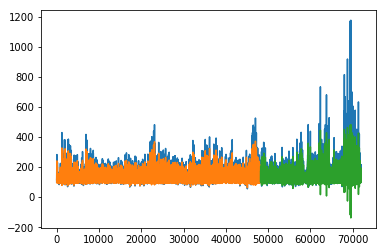

In [25]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(hpi_data2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[tminus:len(trainPredict1)+tminus, :] = trainPredict1
# shift test predictions for plotting
testPredictPlot = np.empty_like(hpi_data2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict1)+(tminus*2)+1:len(hpi_data2)-1, :] = testPredict1
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(hpi_data2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

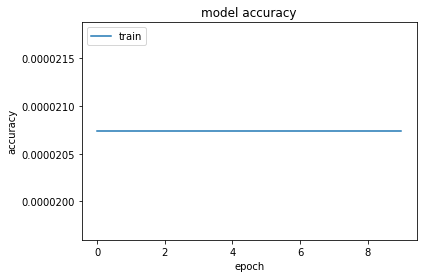

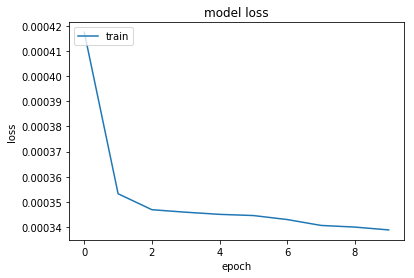

In [27]:
# summarize history for accuracy
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()